In [1]:
# import nistats
import nibabel as nib
import nilearn
from nilearn import image
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map
from nilearn import plotting
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import pickle as pkl

# t1w background image template
# mni09c = '/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'
mni09c = '../sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

%matplotlib inline

/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
# Look-up dictionaries
# contrasts = [('SPD cue > ACC cue', 'T', ['cue_SPDminACC'], [1.0]),
#              ('left > right response', 'T', ['response_leftminright'], [1.0]),
#              ('stimulus_value_difference', 'T', ['stimulus_value_difference'], [1]),
#              ('cuestimrespfeedback', 'T', ['cuestimrespfeedback'], [1]),
#              ('RPE', 'T', ['feedback_PE'], [1])]            
first_level_copes = {'spd > acc': 0,
                     'left > right': 1,
                     'stimulus': 3,
                     'stimulus_value': 2,
                     'rpe': 4
                     }

second_level_copes = {'intercept': 1,
                      '-intercept': 2,
                      'threshold': 3,
                      '-threshold': 4,
                      'urgency': 5,
                      '-urgency': 6}

In [3]:
def merge_pos_neg(pos, neg):
    return image.math_img('pos-neg', pos=pos, neg=neg)

def get_second_level_zmap(first_level_contrast, second_level_contrast, fwhm='1p5', model_n=0, thresholding=None, threshold_z=3.1, hp=False,
                          base_dir='../derivatives/glm_feat/group_level_model/ses-rlsat',
                          from_working_dir=False, 
                          flame='1'):
    cope1 = first_level_copes[first_level_contrast]
    cope2 = second_level_copes[second_level_contrast]
    
    if hp:
        model_suffix = '_hp'
    else:
        model_suffix = ''

    if thresholding is None or thresholding == 'fdr':
        if from_working_dir:
            nii = nib.load(f'../processing/nipype_workflow_folders/feat_level3_rlsat_hp/_contrast_n_{cope1}_fwhm_1p5_model_n_{model_n}/_run_mode_flame{flame}/flameo/stats/zstat{cope2}.nii.gz')
        else:
            nii = nib.load(os.path.join(base_dir, f'model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2}_flame-{flame}_desc-zstat.nii.gz'))
        
        if thresholding is None:
            threshold = 0
        else:
            _, threshold = threshold_stats_img(nii, alpha=0.05, height_control='fdr')
            
    elif thresholding == 'fwer' or thresholding == 'cluster':
        
        # if from_working_dir:
        #     nii = nib.load(f'../processing/nipype_workflow_folders/feat_level3_rlsat/_contrast_n_{cope1}_fwhm_1p5_model_n_{model_n}/_run_mode_{run_mode}/flameo/stats/zstat{cope2}.nii.gz')        
        nii_pos = nib.load(os.path.join(base_dir, f'model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2}_flame-{flame}_desc-zstat_voxelthreshold-{threshold_z}.nii.gz'))
        nii_neg = nib.load(os.path.join(base_dir, f'model-{model_n}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2+1}_flame-{flame}_desc-zstat_voxelthreshold-{threshold_z}.nii.gz'))

        nii = merge_pos_neg(nii_pos, nii_neg)
        threshold = np.min(nii_pos.get_fdata())
        

    return nii, threshold

def plot_4x4(z_map, n_cuts=16, **kwargs):
    cols = rows = int(np.sqrt(n_cuts))
    
    gridspec = dict(hspace=0.0, wspace=0.0, width_ratios=[1, 1, 1, 1])
    f, axes = plt.subplots(4, 4, gridspec_kw=gridspec)
    ax = axes.ravel()
    
    cut_coords = nilearn.plotting.find_cut_slices(z_map, direction='z', n_cuts=n_cuts)
    
    if(z_map.get_fdata().sum() == 0):
        print('No non-zero z-values, nothing to plot!')
        return f, ax
    
    for i in range(n_cuts):
        # plot colorbar in right-most column
        if ((i+1)/cols % cols) == int(((i+1)/cols % cols)):
            colorbar = True
        else:
            colorbar = False
        
        if i == 0 and 'title' in kwargs.keys():
            title = kwargs.pop('title')
        else:
            title = None
        
        plotting.plot_stat_map(z_map, display_mode='z', colorbar=colorbar, title=title,
                               cut_coords=[cut_coords[i]], figure=f, axes=ax[i], **kwargs)
        
    f.set_size_inches(15,15)
    return f, ax

In [4]:
model_n = '1-dm-RTdur'
flame='1'

/tmp/ipykernel_3857363/2217721184.py:47: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  cut_coords = nilearn.plotting.find_cut_slices(z_map, direction='z', n_cuts=n_cuts)


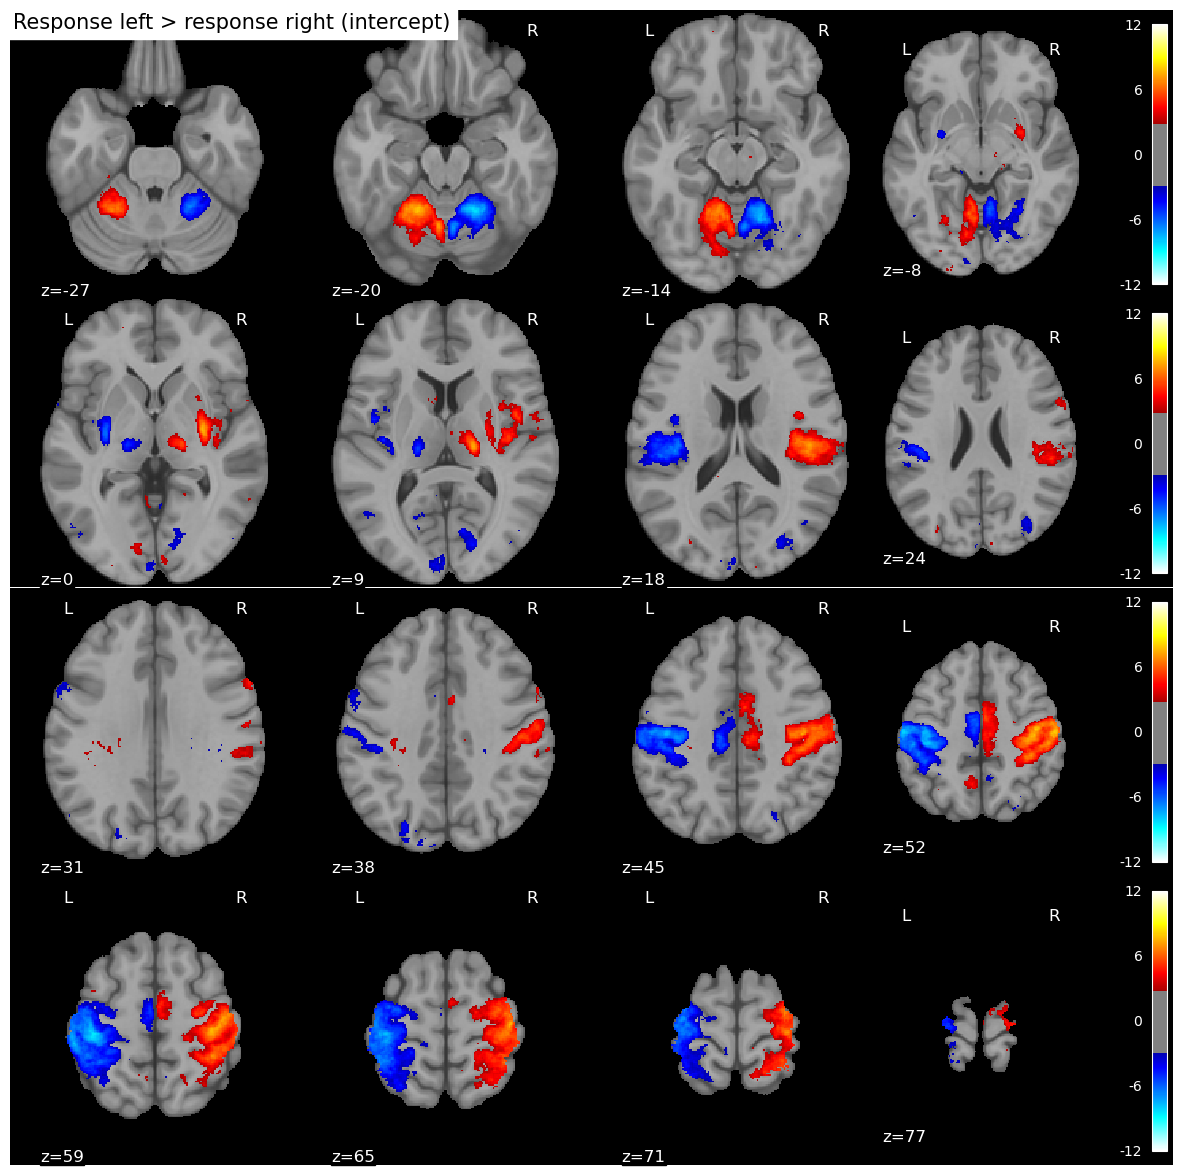

In [5]:
z_map_responselr_intercept, threshold_responselr_fdr = get_second_level_zmap('left > right', 'intercept', thresholding='fdr', model_n=model_n, from_working_dir=False, flame=flame)
f, ax = plot_4x4(z_map_responselr_intercept, threshold=threshold_responselr_fdr, bg_img=mni09c, title='Response left > response right (intercept)', vmax=12)

## Value

/tmp/ipykernel_3857363/2217721184.py:47: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  cut_coords = nilearn.plotting.find_cut_slices(z_map, direction='z', n_cuts=n_cuts)


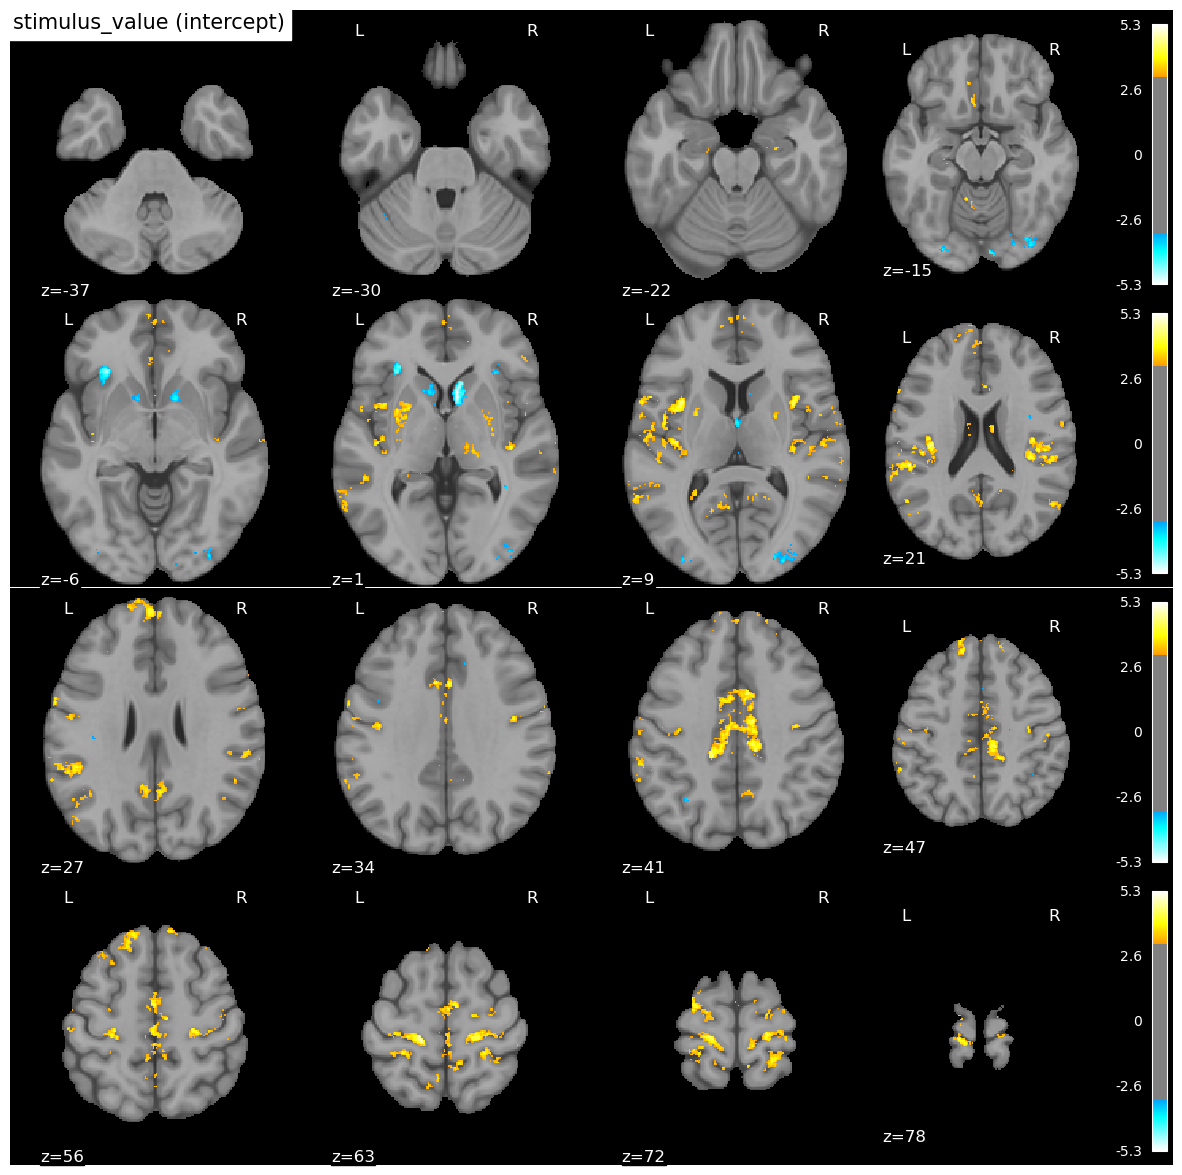

In [6]:
z_map_value, threshold_value_fdr = get_second_level_zmap('stimulus_value', 'intercept', thresholding='fdr', model_n=model_n, from_working_dir=False, flame=flame, hp=False)
f, ax = plot_4x4(z_map_value, threshold=3.2, bg_img=mni09c, title='stimulus_value (intercept)')

## SAT

/tmp/ipykernel_3857363/2217721184.py:47: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  cut_coords = nilearn.plotting.find_cut_slices(z_map, direction='z', n_cuts=n_cuts)


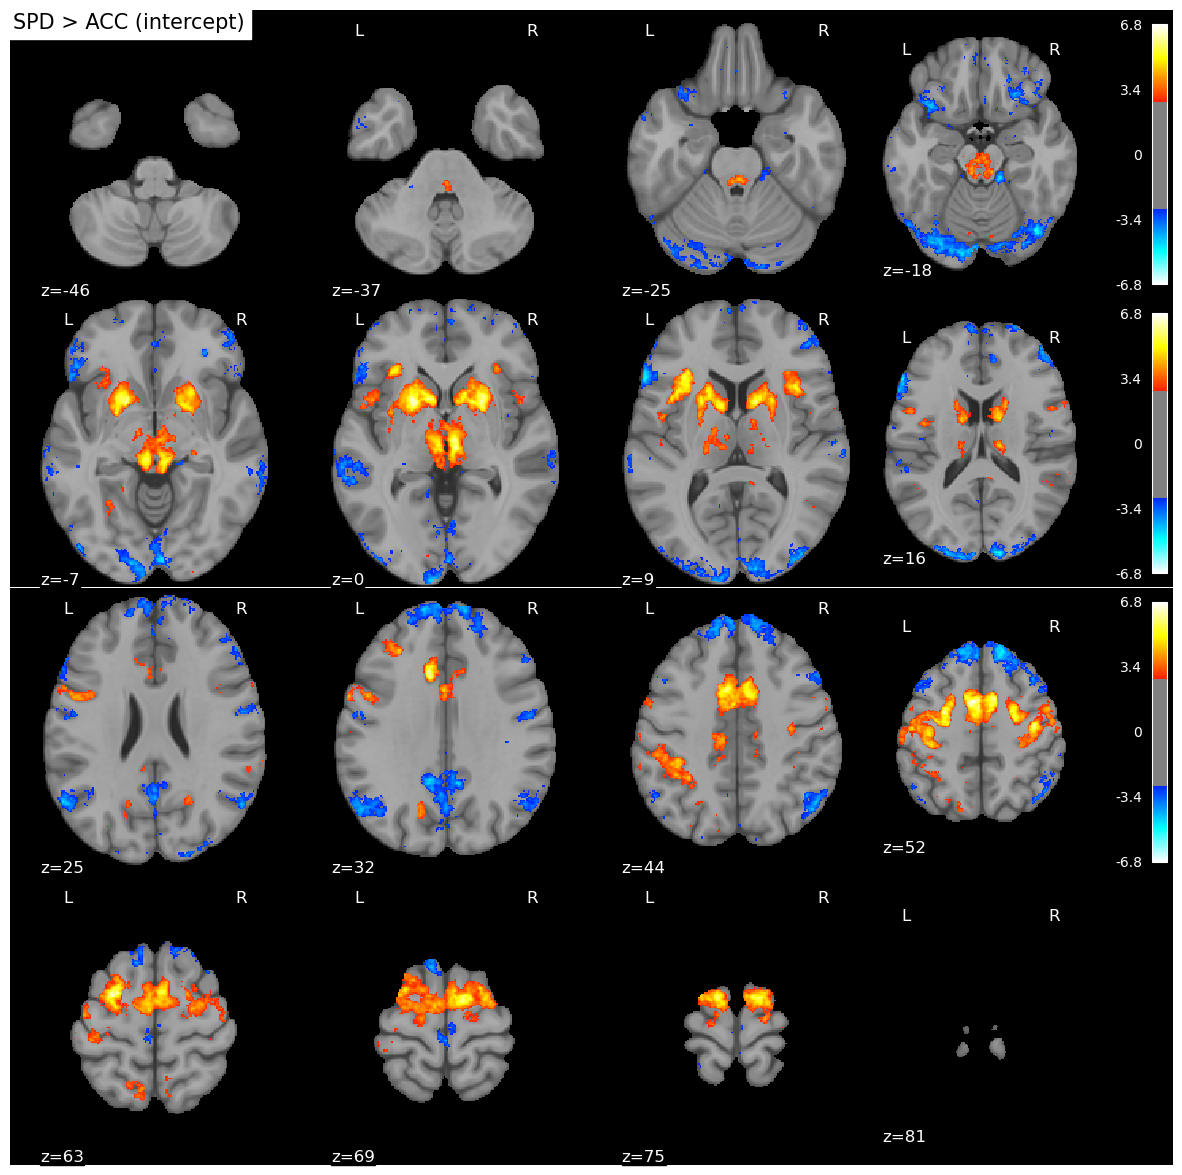

In [7]:
z_map_sat_intercept, threshold_sat_fdr = get_second_level_zmap('spd > acc', 'intercept', thresholding='fdr', model_n=model_n, from_working_dir=False, flame=flame, hp=False)
f, ax = plot_4x4(z_map_sat_intercept, threshold=threshold_sat_fdr, bg_img=mni09c, title='SPD > ACC (intercept)')

/tmp/ipykernel_939548/2217721184.py:47: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  cut_coords = nilearn.plotting.find_cut_slices(z_map, direction='z', n_cuts=n_cuts)


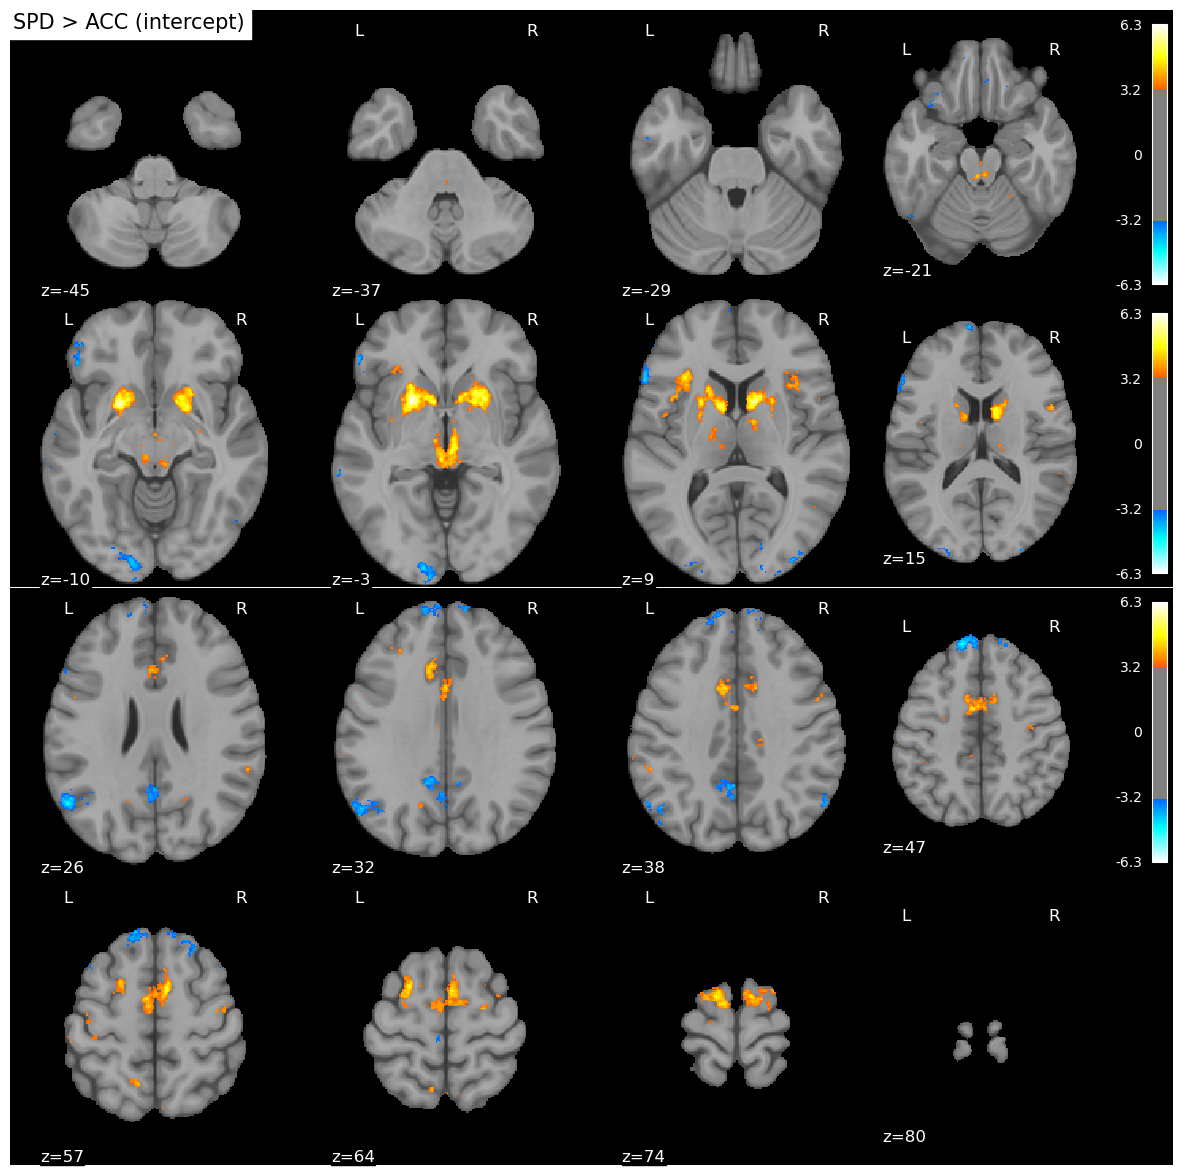

In [13]:
z_map_sat_intercept, threshold_sat_fdr = get_second_level_zmap('spd > acc', 'intercept', thresholding='fdr', model_n=model_n, from_working_dir=False, flame=flame, hp=False)
f, ax = plot_4x4(z_map_sat_intercept, threshold=threshold_sat_fdr, bg_img=mni09c, title='SPD > ACC (intercept)')

/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.840283393859863. But, you have given threshold=inf 
  warnings.warn("The given float value must not exceed {0}. "
/tmp/ipykernel_3857363/2217721184.py:47: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  cut_coords = nilearn.plotting.find_cut_slices(z_map, direction='z', n_cuts=n_cuts)
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


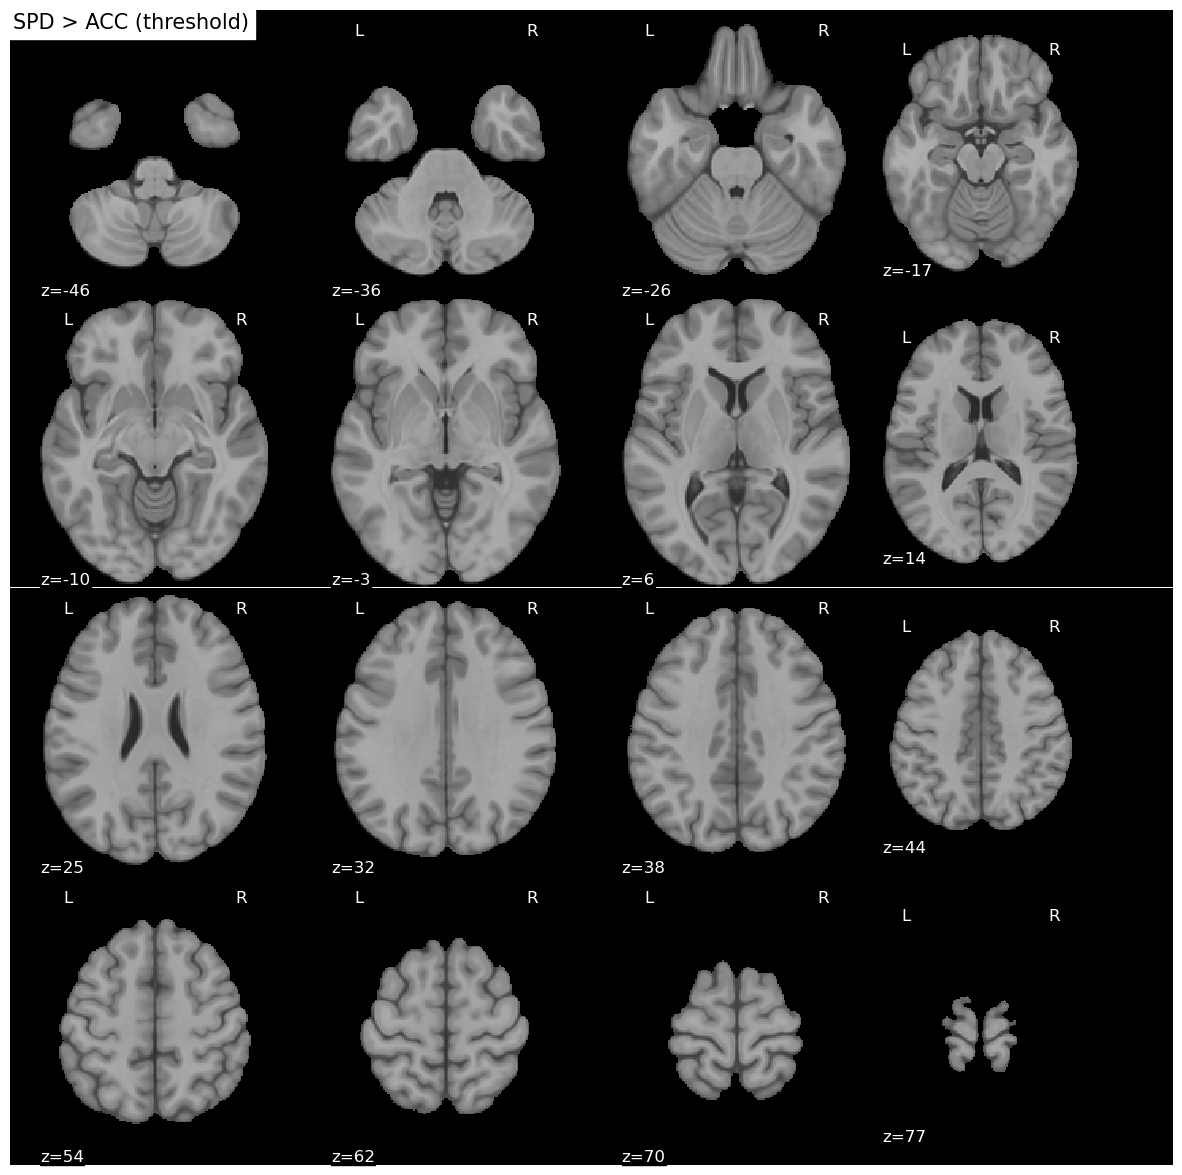

In [8]:
z_map_sat_covariance, threshold_sat_cov_fdr = get_second_level_zmap('spd > acc', 'threshold', thresholding='fdr', model_n=model_n, from_working_dir=False, flame=flame, hp=False)
f, ax = plot_4x4(z_map_sat_covariance, threshold=threshold_sat_cov_fdr, bg_img=mni09c, title='SPD > ACC (threshold)')

/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.3869194984436035. But, you have given threshold=inf 
  warnings.warn("The given float value must not exceed {0}. "
/tmp/ipykernel_939548/2217721184.py:47: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  cut_coords = nilearn.plotting.find_cut_slices(z_map, direction='z', n_cuts=n_cuts)


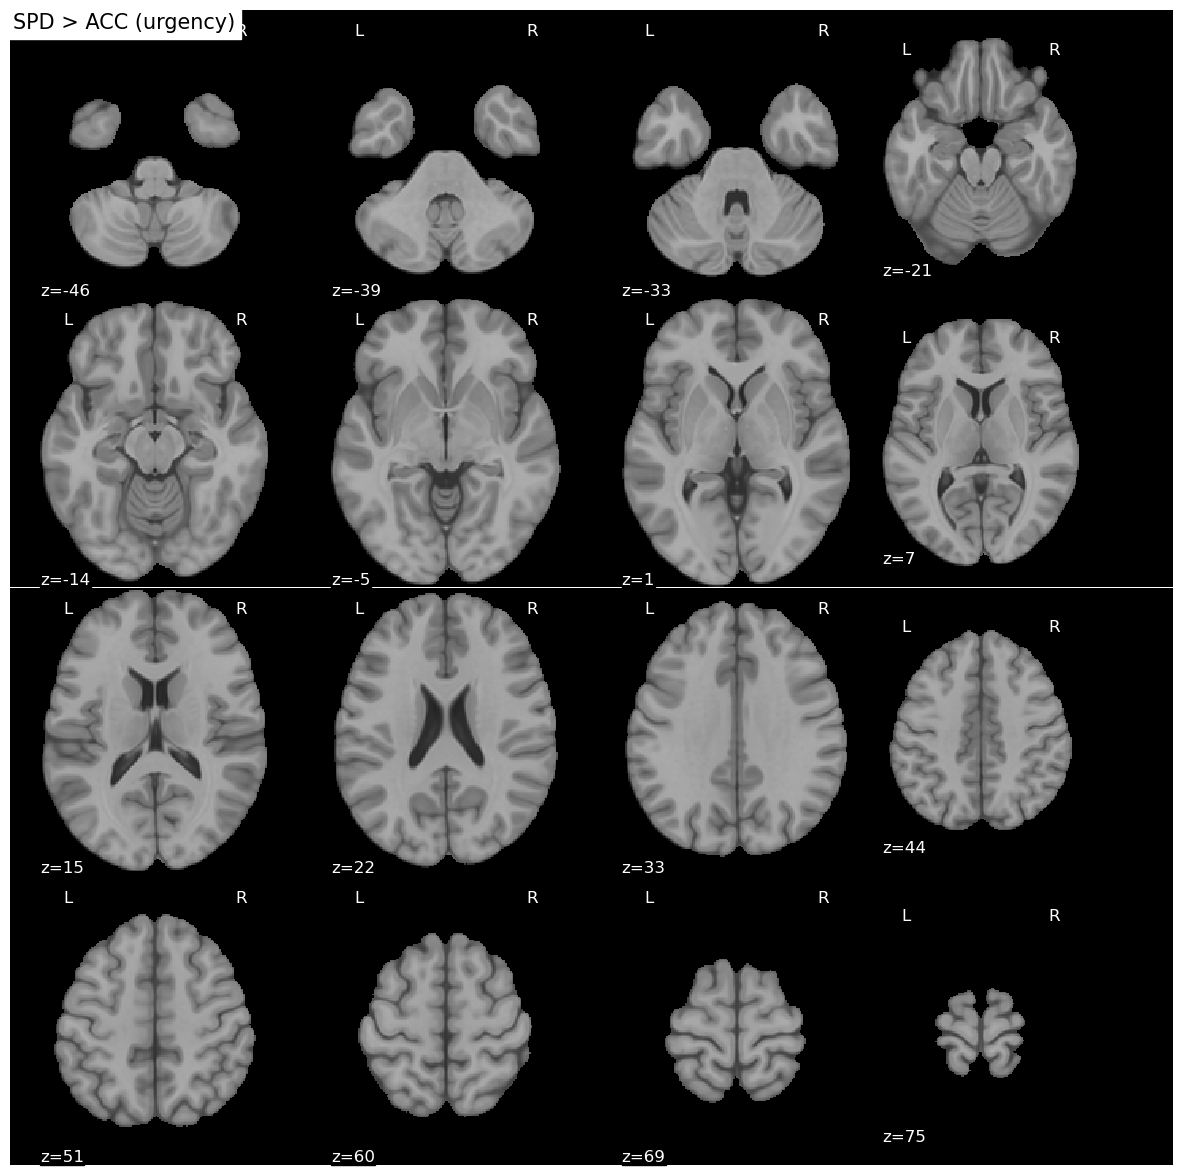

In [15]:
z_map_sat_covariance, threshold_sat_cov_fdr = get_second_level_zmap('spd > acc', 'urgency', thresholding='fdr', model_n=model_n, from_working_dir=False, flame=flame, hp=False)
f, ax = plot_4x4(z_map_sat_covariance, threshold=threshold_sat_cov_fdr, bg_img=mni09c, title='SPD > ACC (urgency)')

## RPE

/tmp/ipykernel_3857363/2217721184.py:47: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  cut_coords = nilearn.plotting.find_cut_slices(z_map, direction='z', n_cuts=n_cuts)


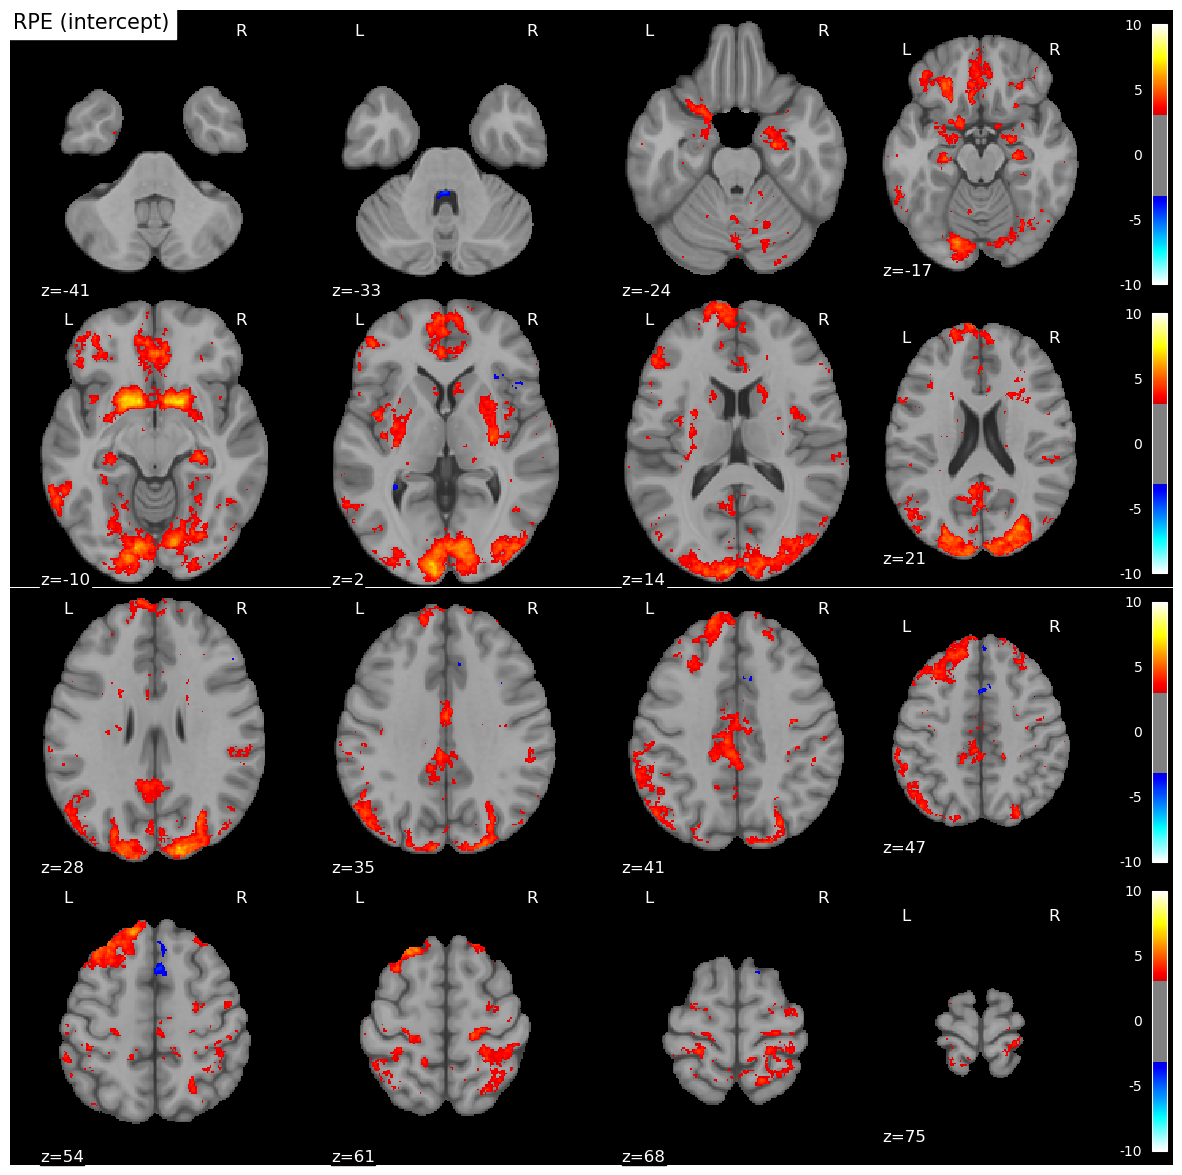

In [9]:
z_map_rpe_intercept, threshold_rpe_fdr = get_second_level_zmap('rpe', 'intercept', thresholding='fdr', model_n=model_n, from_working_dir=False, flame=flame, hp=False)
f, ax = plot_4x4(z_map_rpe_intercept, threshold=3.1, bg_img=mni09c, title='RPE (intercept)', vmax=10)

/tmp/ipykernel_939548/2217721184.py:47: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  cut_coords = nilearn.plotting.find_cut_slices(z_map, direction='z', n_cuts=n_cuts)


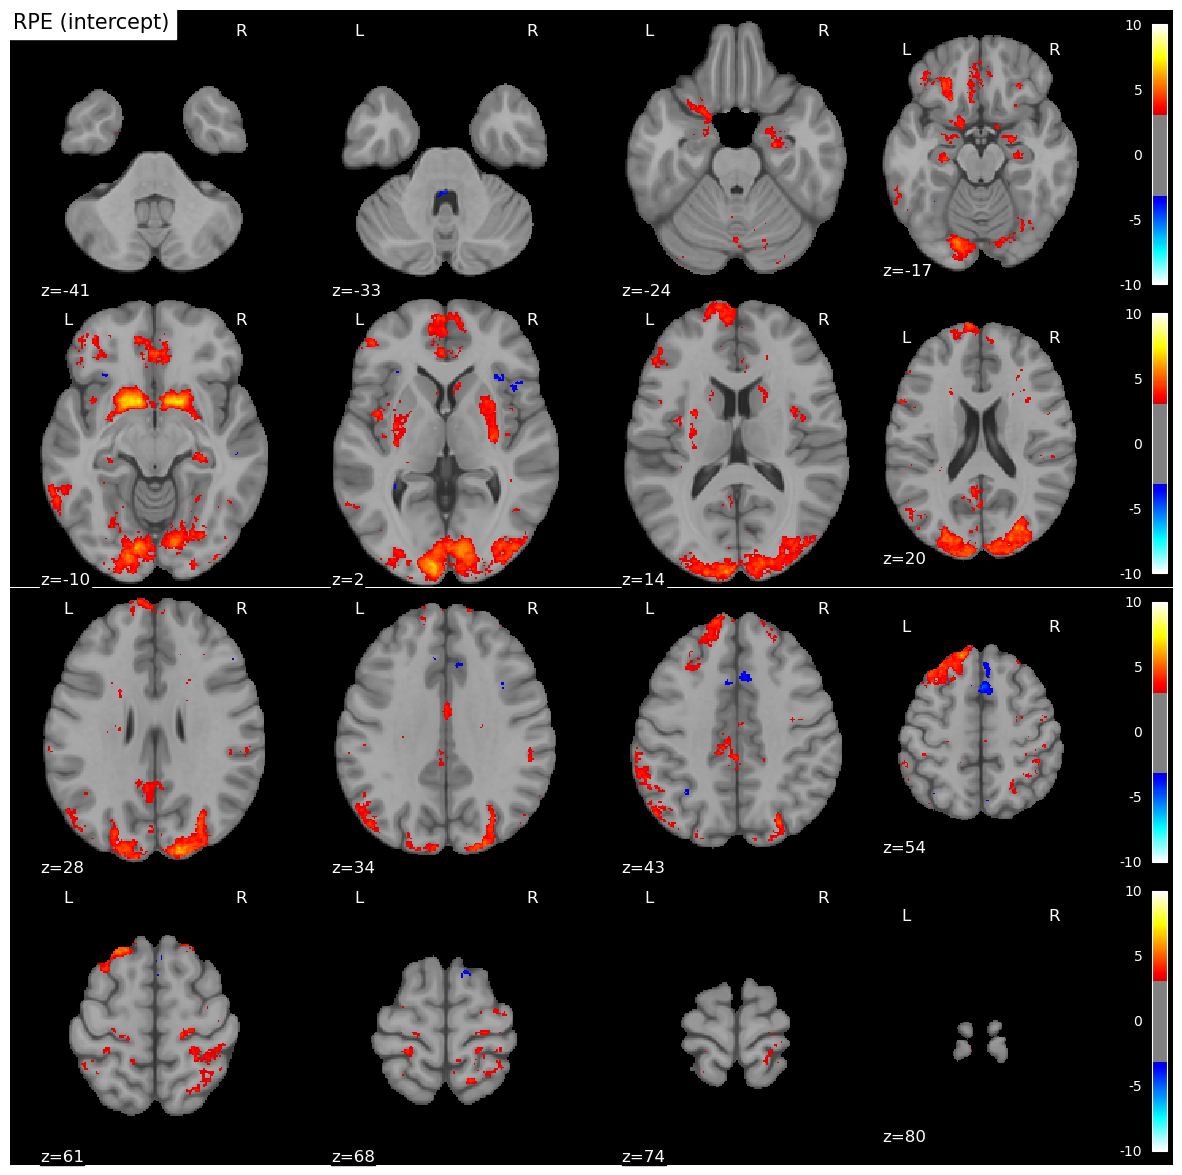

In [16]:
z_map_rpe_intercept, threshold_rpe_fdr = get_second_level_zmap('rpe', 'intercept', thresholding='fdr', model_n=model_n, from_working_dir=False, flame=flame, hp=False)
f, ax = plot_4x4(z_map_rpe_intercept, threshold=3.1, bg_img=mni09c, title='RPE (intercept)', vmax=10)

# Figure for paper/chapter

In [10]:
import nilearn
from nilearn import plotting

def draw_custom_colorbar(colorbar_ax, vmin=3, vmax=6, truncation_limits=(0,6), offset=4., nb_ticks=4, flip=True,
                         format="%.1f", cmap=plotting.cm.cold_hot, tick_left=True, tick_right=False, is_symmetric=True):
    from matplotlib.colorbar import ColorbarBase
    from matplotlib import colors
    our_cmap = cmap
    if flip:
        truncation_limits = [truncation_limits[1], truncation_limits[0]]
    
    if nb_ticks > 0:
        ticks = np.linspace(truncation_limits[0], truncation_limits[1], nb_ticks)
    else:
        ticks = []
    bounds = np.linspace(truncation_limits[0], truncation_limits[1], our_cmap.N)
    if is_symmetric:
        norm = colors.Normalize(vmin=-vmax, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    
    # some colormap hacking
    cmaplist = [our_cmap(i) for i in range(our_cmap.N)]
    istart = int(norm(-offset, clip=True) * (our_cmap.N - 1))
    istop = int(norm(offset, clip=True) * (our_cmap.N - 1))
    for i in range(istart, istop):
        cmaplist[i] = (0.5, 0.5, 0.5, 1.)  # just an average gray color
    our_cmap = our_cmap.from_list('Custom cmap', cmaplist, our_cmap.N)

    ColorbarBase(colorbar_ax, ticks=ticks, norm=norm,
                 orientation='vertical', cmap=our_cmap, boundaries=bounds,
                 spacing='proportional', format=format)
    
    if flip:
        colorbar_ax.invert_yaxis()
    if tick_left:
        colorbar_ax.yaxis.tick_left()
    if tick_right:
        colorbar_ax.yaxis.tick_right()

    return colorbar_ax

## all combined

In [35]:
# load SPMs
z_map_responselr_intercept, threshold_responselr_fdr = get_second_level_zmap('left > right', 'intercept', thresholding='fdr', model_n='1-dm-RTdur', from_working_dir=False, flame='12')
z_map_sat_intercept, threshold_sat_fdr = get_second_level_zmap('spd > acc', 'intercept', thresholding='fdr', model_n='1-dm-RTdur', from_working_dir=False, flame='12')
z_map_value, threshold_value_fdr = get_second_level_zmap('stimulus_value', 'intercept', thresholding='fdr', model_n='1-dm-RTdur', from_working_dir=False, flame='12')
z_map_rpe_intercept, threshold_rpe_fdr = get_second_level_zmap('rpe', 'intercept', thresholding='fdr', model_n='1-dm-RTdur', from_working_dir=False, flame='12')


## ensure at least z>3.1 (NB: FDR can give some quite liberal thresholds)
threshold_responselr_fdr = np.maximum(threshold_responselr_fdr, 3.1)
threshold_sat_fdr = np.maximum(threshold_sat_fdr, 3.1)
threshold_value_fdr = np.maximum(threshold_value_fdr, 3.1)
threshold_rpe_fdr = np.maximum(threshold_rpe_fdr, 3.1)

### 4 contrasts

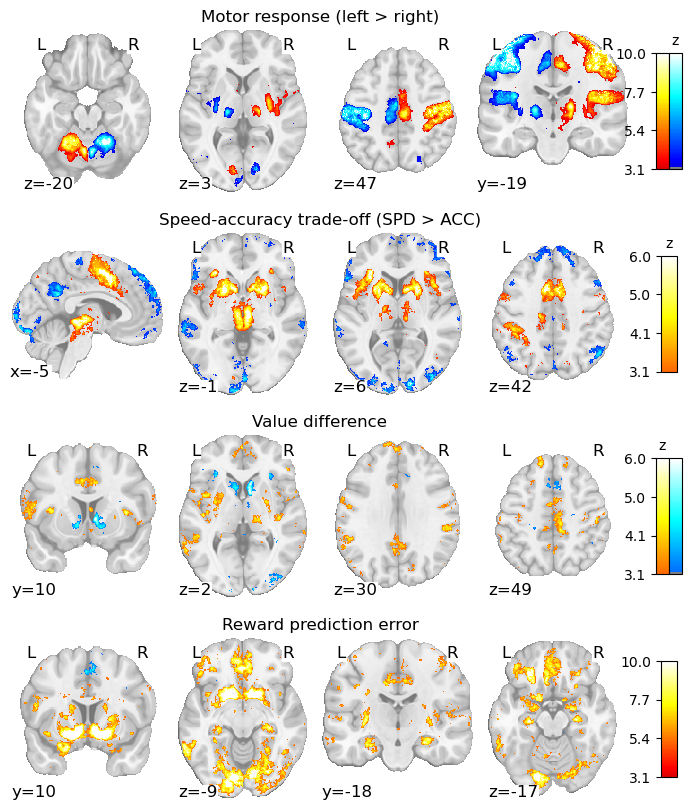

In [36]:
font = {'size': 10}
lines = {'linewidth': 0.5}
import matplotlib
matplotlib.rc('font', **font)
matplotlib.rc('lines', **lines)
f = plt.figure(figsize=(9,10))
gridspec = f.add_gridspec(ncols=2, nrows=4, 
                          hspace=0.25, wspace=0.0, 
                          width_ratios=[8,1])
ax0 = f.add_subplot(gridspec[0,0])
ax0.axis('off')
ax0.set_title('Motor response (left > right)')

ax1 = f.add_subplot(gridspec[1,0])
ax1.axis('off')
ax1.set_title('Speed-accuracy trade-off (SPD > ACC)')

ax2 = f.add_subplot(gridspec[2,0])
ax2.axis('off')
ax2.set_title('Value difference')

ax3 = f.add_subplot(gridspec[3,0])
ax3.axis('off')
ax3.set_title('Reward prediction error')

## responses
gs00 = gridspec[0,0].subgridspec(1, 4, hspace=0, wspace=0)
vmax_, threshold_ = 10, np.max([threshold_responselr_fdr, 3.1])
for i, (display_mode, cut_coord) in enumerate(zip(['z', 'z', 'z', 'y'], [-20, 3, 47, -19])):
    d = plotting.plot_anat(mni09c, cut_coords=[cut_coord], display_mode=display_mode, figure=f, axes=f.add_subplot(gs00[i]), black_bg=False, threshold=0.01)
    d.add_overlay(z_map_responselr_intercept, threshold=threshold_, cmap=nilearn.plotting.cm.cold_hot, vmax=vmax_, vmin=-vmax_)
# colorbar
gs01 = gridspec[0,1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs01[1,1]), 
                                truncation_limits=(threshold_, vmax_), vmax=vmax_, offset=threshold_, flip=False, tick_left=True)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs01[1,2]), 
                                truncation_limits=(-threshold_,-vmax_), vmax=vmax_, offset=threshold_, flip=True, tick_left=False, nb_ticks=0)
cbar_ax2.set_title('z', rotation=0, fontsize=10, ha='center')

## SAT
gs10 = gridspec[1,0].subgridspec(1, 4, hspace=0, wspace=0)
vmax_, threshold_ = 6, np.max([threshold_sat_fdr, 3.1])
for i, (display_mode, cut_coord) in enumerate(zip(['x', 'z', 'z', 'z'], [-5, -1, 6, 42])):
    d = plotting.plot_anat(mni09c, cut_coords=[cut_coord], display_mode=display_mode, figure=f, axes=f.add_subplot(gs10[i]), black_bg=False, threshold=0.01)
    d.add_overlay(z_map_sat_intercept, threshold=threshold_, cmap=nilearn.plotting.cm.cold_hot, vmax=7.5, vmin=-7.5)
# colorbar
gs11 = gridspec[1,1].subgridspec(3, 3, hspace=0, wspace=0, width_ratios=[2, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs11[1,1]), truncation_limits=(threshold_, vmax_), vmax=vmax_, offset=threshold_, flip=False, tick_left=True)
cbar_ax1.set_title('z', rotation=0, fontsize=10, ha='center')


## Value
gs20 = gridspec[2,0].subgridspec(1, 4, hspace=0, wspace=0)
vmax_, threshold_= 6, np.max([threshold_value_fdr, 3.1])
for i, (display_mode, cut_coord) in enumerate(zip(['y', 'z', 'z', 'z'], [10, 2, 30, 49])):
    d = plotting.plot_anat(mni09c, cut_coords=[cut_coord], display_mode=display_mode, figure=f, axes=f.add_subplot(gs20[i]), black_bg=False, threshold=0.01)
    d.add_overlay(z_map_value, threshold=threshold_, cmap=nilearn.plotting.cm.cold_hot, vmax=6, vmin=-6)
# colorbar
gs21 = gridspec[2,1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs21[1,1]), truncation_limits=(threshold_, vmax_), vmax=vmax_, offset=threshold_, flip=False, tick_left=True)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs21[1,2]), truncation_limits=(-threshold_,-vmax_), vmax=vmax_, offset=threshold_, flip=True, tick_left=False, nb_ticks=0)
cbar_ax1.set_title('z', rotation=0, fontsize=10, ha='center') #, pad=75)

## RPE
gs30 = gridspec[3,0].subgridspec(1, 4, hspace=0, wspace=0)
vmax_, threshold_ = 10, np.max([threshold_rpe_fdr, 3.1]) #threshold_rpe_fdr
for i, (display_mode, cut_coord) in enumerate(zip(['y', 'z', 'y', 'z'], [10, -9, -18, -17])):
    d = plotting.plot_anat(mni09c, cut_coords=[cut_coord], display_mode=display_mode, figure=f, axes=f.add_subplot(gs30[i]), black_bg=False, threshold=0.01)
    d.add_overlay(z_map_rpe_intercept, threshold=threshold_, cmap=nilearn.plotting.cm.cold_hot, vmax=6, vmin=-6)
# colorbar
gs31 = gridspec[3,1].subgridspec(3, 3, hspace=0, wspace=0, width_ratios=[2, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs31[1,1]), truncation_limits=(threshold_, vmax_), vmax=vmax_, offset=threshold_, flip=False, tick_left=True)

# f.savefig('../figures/rlsat/spms_wholebrain_4contrasts.pdf', bbox_inches='tight')

#### 3 contrasts (Get rid of motor)

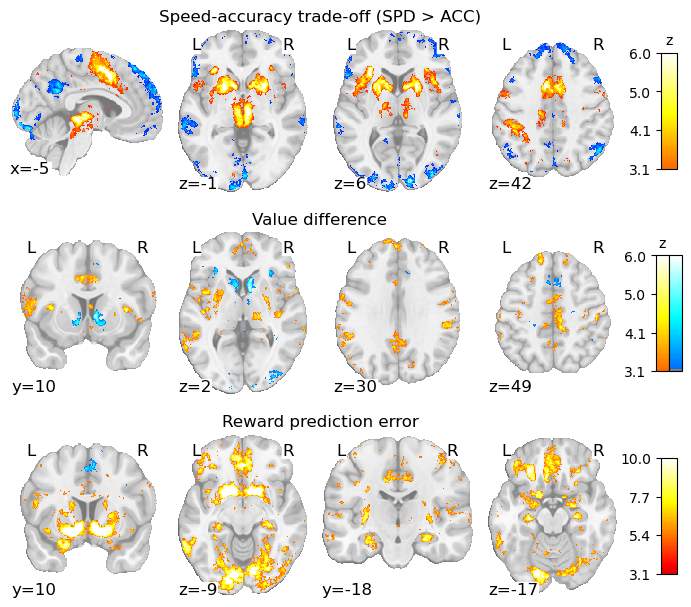

In [37]:
font = {'size': 10}
lines = {'linewidth': 0.5}
import matplotlib
matplotlib.rc('font', **font)
matplotlib.rc('lines', **lines)
f = plt.figure(figsize=(9,10))
gridspec = f.add_gridspec(ncols=2, nrows=4, 
                          hspace=0.25, wspace=0.0, 
                          width_ratios=[8,1])
ax0 = f.add_subplot(gridspec[0,0])
ax0.axis('off')
ax0.set_title('Speed-accuracy trade-off (SPD > ACC)')

ax1 = f.add_subplot(gridspec[1,0])
ax1.axis('off')
ax1.set_title('Value difference')

ax2 = f.add_subplot(gridspec[2,0])
ax2.axis('off')
ax2.set_title('Reward prediction error')

## SAT
gs10 = gridspec[0,0].subgridspec(1, 4, hspace=0, wspace=0)
vmax_, threshold_ = 6, np.max([threshold_sat_fdr, 3.1])
for i, (display_mode, cut_coord) in enumerate(zip(['x', 'z', 'z', 'z'], [-5, -1, 6, 42])):
    d = plotting.plot_anat(mni09c, cut_coords=[cut_coord], display_mode=display_mode, figure=f, axes=f.add_subplot(gs10[i]), black_bg=False, threshold=0.01)
    d.add_overlay(z_map_sat_intercept, threshold=threshold_, cmap=nilearn.plotting.cm.cold_hot, vmax=7.5, vmin=-7.5)
# colorbar
gs11 = gridspec[0,1].subgridspec(3, 3, hspace=0, wspace=0, width_ratios=[2, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs11[1,1]), truncation_limits=(threshold_, vmax_), vmax=vmax_, offset=threshold_, flip=False, tick_left=True)
cbar_ax1.set_title('z', rotation=0, fontsize=10, ha='center')


## Value
gs20 = gridspec[1,0].subgridspec(1, 4, hspace=0, wspace=0)
vmax_, threshold_= 6, np.max([threshold_value_fdr, 3.1])
for i, (display_mode, cut_coord) in enumerate(zip(['y', 'z', 'z', 'z'], [10, 2, 30, 49])):
    d = plotting.plot_anat(mni09c, cut_coords=[cut_coord], display_mode=display_mode, figure=f, axes=f.add_subplot(gs20[i]), black_bg=False, threshold=0.01)
    d.add_overlay(z_map_value, threshold=threshold_, cmap=nilearn.plotting.cm.cold_hot, vmax=6, vmin=-6)
# colorbar
gs21 = gridspec[1,1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs21[1,1]), truncation_limits=(threshold_, vmax_), vmax=vmax_, offset=threshold_, flip=False, tick_left=True)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs21[1,2]), truncation_limits=(-threshold_,-vmax_), vmax=vmax_, offset=threshold_, flip=True, tick_left=False, nb_ticks=0)
cbar_ax1.set_title('z', rotation=0, fontsize=10, ha='center') #, pad=75)

## RPE
gs30 = gridspec[2,0].subgridspec(1, 4, hspace=0, wspace=0)
vmax_, threshold_ = 10, np.max([threshold_rpe_fdr, 3.1]) #threshold_rpe_fdr
for i, (display_mode, cut_coord) in enumerate(zip(['y', 'z', 'y', 'z'], [10, -9, -18, -17])):
    d = plotting.plot_anat(mni09c, cut_coords=[cut_coord], display_mode=display_mode, figure=f, axes=f.add_subplot(gs30[i]), black_bg=False, threshold=0.01)
    d.add_overlay(z_map_rpe_intercept, threshold=threshold_, cmap=nilearn.plotting.cm.cold_hot, vmax=6, vmin=-6)
# colorbar
gs31 = gridspec[2,1].subgridspec(3, 3, hspace=0, wspace=0, width_ratios=[2, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs31[1,1]), truncation_limits=(threshold_, vmax_), vmax=vmax_, offset=threshold_, flip=False, tick_left=True)

f.savefig('../figures/rlsat/spms_wholebrain_3contrasts_nomotor_RTdur.pdf', bbox_inches='tight')

## Focus on subcortex

In [38]:
massp_fns = sorted(glob.glob('../sourcedata/massp_young_atlas_from_figshare/massp2021-subcortex_avg-*_hem-*_decade-18to40_n54.nii.gz'))
massp_fns

color_dict = {'amg': 'red',
              'cl': 'orange',
              'fx': 'lightgrey',
              'gpe': 'darkblue',
              'gpi': 'lightblue',
              'ic': 'darkorange',
              'pag': 'grey',
              'ppn': 'blue',
              'rn': 'red',
              'sn': 'black',
              'stn': 'purple',
              'str': 'lightgreen',
              'tha': 'darkgreen',
              'vent': 'white',
              'vta': 'darkgreen'}

import re
regex = re.compile('.*_avg-(?P<roi>\S+)_hem-(?P<hemi>\S+)_decade.*')

mask_dict = {}
for roi in color_dict.keys():
    fns = sorted(glob.glob(f'../sourcedata/massp_young_atlas_from_figshare/massp2021-subcortex_avg-{roi}_hem-*_decade-18to40_n54.nii.gz'))
    imgs = nilearn.image.concat_imgs(fns) 
    ## sum left and right
    imgs = nib.Nifti1Image(imgs.get_fdata().sum(-1), header=imgs.header, affine=imgs.affine)
    mask_dict[roi] = imgs


def zoom_in(ylims, proportion=.5):
    range_ = ylims[1]-ylims[0]
    center = ylims[0]+(ylims[1]-ylims[0])/2
    new_range = range_*proportion
    return (center-(new_range/2), center+(new_range/2))

### 2 contrasts only

amg


/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


cl
fx
gpe
gpi
ic
pag
ppn
rn
sn
stn
str
tha
vent
vta
amg
cl
fx
gpe
gpi
ic
pag
ppn
rn
sn
stn
str
tha
vent
vta
amg
cl
fx
gpe
gpi
ic
pag
ppn
rn
sn
stn
str
tha
vent
vta
amg
cl
fx
gpe
gpi
ic
pag
ppn
rn
sn
stn
str
tha
vent
vta


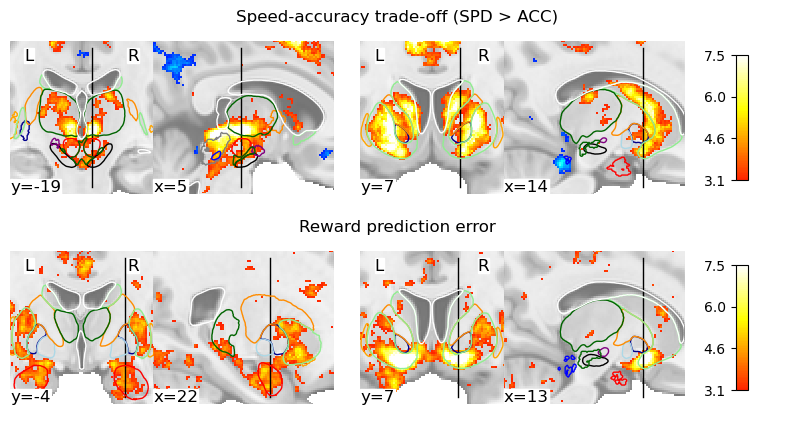

In [39]:
font = {'size': 10}
lines = {'linewidth': 1}
import matplotlib
matplotlib.rc('font', **font)
matplotlib.rc('lines', **lines)
f = plt.figure(figsize=(10,5))
gridspec = f.add_gridspec(ncols=5, nrows=2, 
                          hspace=.2, wspace=.2,
                          width_ratios=np.array([1,1,1,1,0.5]).ravel().tolist())
ax0 = f.add_subplot(gridspec[0,:5])
ax0.axis('off')
ax0.set_title('Speed-accuracy trade-off (SPD > ACC)')

ax0 = f.add_subplot(gridspec[1,:5])
ax0.set_title('Reward prediction error')
ax0.axis('off')


# SAT 1
g = plotting.plot_stat_map(z_map_sat_intercept,
                           threshold=threshold_sat_fdr, 
                           display_mode='yx', 
                           colorbar=False, 
                           vmax=7.5,
                           cut_coords=[5, -19], 
                           bg_img=mni09c,
                           black_bg=False, axes=f.add_subplot(gridspec[0,0:2]))

## zoom in    
g.axes['y'].ax.set_ylim(*zoom_in(g.axes['y'].ax.get_ylim(), .5))
g.axes['y'].ax.set_xlim(*zoom_in(g.axes['y'].ax.get_xlim(), .5))
g.axes['x'].ax.set_ylim(*zoom_in(g.axes['x'].ax.get_ylim(), .5))
g.axes['x'].ax.set_xlim(*zoom_in(g.axes['x'].ax.get_xlim(), .5))

# add contours   -- this is pretty slow, comment out for faster developing
for roi,color in color_dict.items():
    print(roi, end='...')
    g.add_contours(mask_dict[roi], levels=[0.5], colors=color) 

# SAT 2
g = plotting.plot_stat_map(z_map_sat_intercept,
                           threshold=threshold_sat_fdr, 
                           display_mode='yx', 
                           colorbar=False, 
                           vmax=7.5,
                           cut_coords=[14, 7], 
                           bg_img=mni09c,
                           black_bg=False, axes=f.add_subplot(gridspec[0,2:4]))

## zoom in    
g.axes['y'].ax.set_ylim(*zoom_in(g.axes['y'].ax.get_ylim(), .5))
g.axes['y'].ax.set_xlim(*zoom_in(g.axes['y'].ax.get_xlim(), .5))
g.axes['x'].ax.set_ylim(*zoom_in(g.axes['x'].ax.get_ylim(), .5))
g.axes['x'].ax.set_xlim(*zoom_in(g.axes['x'].ax.get_xlim(), .5))

# add contours   -- this is pretty slow, comment out for faster developing
for roi,color in color_dict.items():
    print(roi, end='...')
    g.add_contours(mask_dict[roi], levels=[0.5], colors=color) 

# colorbar
gs00 = gridspec[0,-1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs00[1,1]), 
                                truncation_limits=(threshold_sat_fdr, 7.5), vmax=7.5, offset=threshold_sat_fdr, flip=False, tick_left=True)


# RPE 1
g = plotting.plot_stat_map(z_map_rpe_intercept,
                           threshold=threshold_rpe_fdr, 
                           display_mode='yx', 
                           colorbar=False, 
                           vmax=7.5,
                           cut_coords=[22, -4], 
                           bg_img=mni09c,
                           black_bg=False, axes=f.add_subplot(gridspec[1,0:2]))

## zoom in    
g.axes['y'].ax.set_ylim(*zoom_in(g.axes['y'].ax.get_ylim(), .5))
g.axes['y'].ax.set_xlim(*zoom_in(g.axes['y'].ax.get_xlim(), .5))
g.axes['x'].ax.set_ylim(*zoom_in(g.axes['x'].ax.get_ylim(), .5))
g.axes['x'].ax.set_xlim(*zoom_in(g.axes['x'].ax.get_xlim(), .5))

# add contours   -- this is pretty slow, comment out for faster developing
for roi,color in color_dict.items():
    print(roi, end='...')
    g.add_contours(mask_dict[roi], levels=[0.5], colors=color) 

# RPE 2
g = plotting.plot_stat_map(z_map_rpe_intercept,
                           threshold=threshold_rpe_fdr, 
                           display_mode='yx', 
                           colorbar=False, 
                           vmax=7.5,
                           cut_coords=[13, 7], 
                           bg_img=mni09c,
                           black_bg=False, axes=f.add_subplot(gridspec[1,2:4]))

## zoom in    
g.axes['y'].ax.set_ylim(*zoom_in(g.axes['y'].ax.get_ylim(), .5))
g.axes['y'].ax.set_xlim(*zoom_in(g.axes['y'].ax.get_xlim(), .5))
g.axes['x'].ax.set_ylim(*zoom_in(g.axes['x'].ax.get_ylim(), .5))
g.axes['x'].ax.set_xlim(*zoom_in(g.axes['x'].ax.get_xlim(), .5))

# add contours   -- this is pretty slow, comment out for faster developing
for roi,color in color_dict.items():
    print(roi, end='...')
    g.add_contours(mask_dict[roi], levels=[0.5], colors=color) 

# colorbar
gs00 = gridspec[1,-1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs00[1,1]), 
                                truncation_limits=(threshold_rpe_fdr, 7.5), vmax=7.5, offset=threshold_rpe_fdr, flip=False, tick_left=True)

In [41]:
f.savefig('../figures/rlsat/SPMs_subcortex_RTdur.pdf', bbox_inches='tight')

## 3 contrasts, include value differences

amg...

/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


cl...fx...gpe...gpi...ic...pag...ppn...rn...sn...stn...str...tha...vent...vta...amg
cl
fx
gpe
gpi
ic
pag
ppn
rn
sn
stn
str
tha
vent
vta
amg...cl...fx...gpe...gpi...ic...pag...ppn...rn...sn...stn...str...tha...vent...vta...amg...cl...fx...gpe...gpi...ic...pag...ppn...rn...sn...stn...str...tha...vent...vta...amg...cl...fx...gpe...gpi...ic...pag...ppn...rn...sn...stn...str...tha...vent...vta...amg...cl...fx...gpe...gpi...ic...pag...ppn...rn...sn...stn...str...tha...vent...vta...

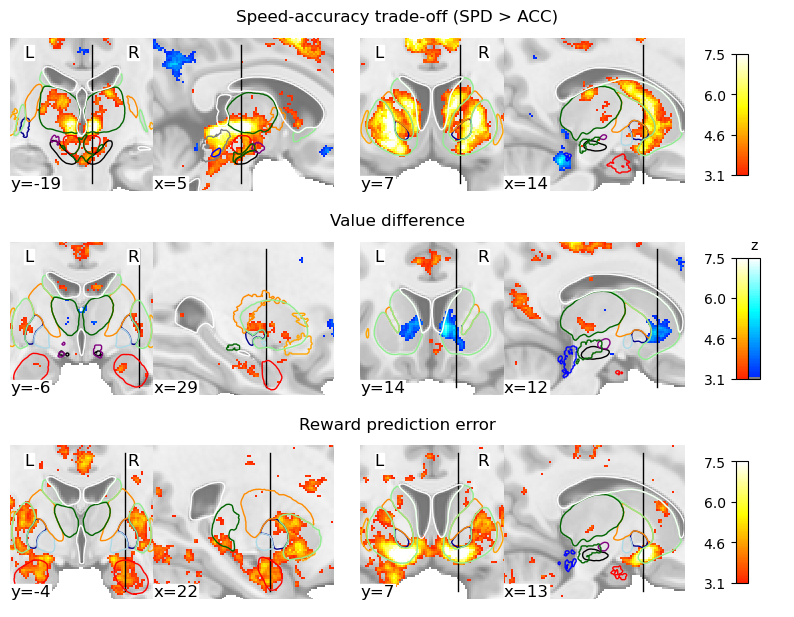

In [42]:
do_contours=True

font = {'size': 10, 'family': 'sans-serif', 'sans-serif': 'DejaVu Sans'}
lines = {'linewidth': 1}
import matplotlib
matplotlib.rc('font', **font)
matplotlib.rc('lines', **lines)
f = plt.figure(figsize=(10,7.5))
gridspec = f.add_gridspec(ncols=5, nrows=3, 
                          hspace=.2, wspace=.2,
                          width_ratios=np.array([1,1,1,1,0.5]).ravel().tolist())
ax0 = f.add_subplot(gridspec[0,:5])
ax0.axis('off')
ax0.set_title('Speed-accuracy trade-off (SPD > ACC)')

ax0 = f.add_subplot(gridspec[1,:5])
ax0.set_title('Value difference')
ax0.axis('off')

ax0 = f.add_subplot(gridspec[2,:5])
ax0.set_title('Reward prediction error')
ax0.axis('off')


# SAT 1
g = plotting.plot_stat_map(z_map_sat_intercept,
                           threshold=threshold_sat_fdr, 
                           display_mode='yx', 
                           colorbar=False, 
                           vmax=7.5,
                           cut_coords=[5, -19], 
                           bg_img=mni09c,
                           black_bg=False, axes=f.add_subplot(gridspec[0,0:2]))

## zoom in    
g.axes['y'].ax.set_ylim(*zoom_in(g.axes['y'].ax.get_ylim(), .5))
g.axes['y'].ax.set_xlim(*zoom_in(g.axes['y'].ax.get_xlim(), .5))
g.axes['x'].ax.set_ylim(*zoom_in(g.axes['x'].ax.get_ylim(), .5))
g.axes['x'].ax.set_xlim(*zoom_in(g.axes['x'].ax.get_xlim(), .5))

# add contours   -- this is pretty slow, comment out for faster developing
if do_contours:
    for roi,color in color_dict.items():
        print(roi, end='...')
        g.add_contours(mask_dict[roi], levels=[0.5], colors=color) 

# SAT 2
g = plotting.plot_stat_map(z_map_sat_intercept,
                           threshold=threshold_sat_fdr, 
                           display_mode='yx', 
                           colorbar=False, 
                           vmax=7.5,
                           cut_coords=[14, 7], 
                           bg_img=mni09c,
                           black_bg=False, axes=f.add_subplot(gridspec[0,2:4]))

## zoom in    
g.axes['y'].ax.set_ylim(*zoom_in(g.axes['y'].ax.get_ylim(), .5))
g.axes['y'].ax.set_xlim(*zoom_in(g.axes['y'].ax.get_xlim(), .5))
g.axes['x'].ax.set_ylim(*zoom_in(g.axes['x'].ax.get_ylim(), .5))
g.axes['x'].ax.set_xlim(*zoom_in(g.axes['x'].ax.get_xlim(), .5))

# add contours   -- this is pretty slow, comment out for faster developing
if do_contours:
    for roi,color in color_dict.items():
        print(roi, end='...')
        g.add_contours(mask_dict[roi], levels=[0.5], colors=color) 

gs00 = gridspec[0,-1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs00[1,1]), 
                                truncation_limits=(threshold_sat_fdr, 7.5), vmax=7.5, offset=threshold_sat_fdr, flip=False, tick_left=True)


# Value 1
g = plotting.plot_stat_map(z_map_value,
                           threshold=threshold_value_fdr, 
                           display_mode='yx', 
                           colorbar=False, 
                           vmax=7.5,
                           cut_coords=[29, -6], 
                           bg_img=mni09c,
                           black_bg=False, axes=f.add_subplot(gridspec[1,0:2]))

## zoom in
g.axes['y'].ax.set_ylim(*zoom_in(g.axes['y'].ax.get_ylim(), .5))
g.axes['y'].ax.set_xlim(*zoom_in(g.axes['y'].ax.get_xlim(), .5))
g.axes['x'].ax.set_ylim(*zoom_in(g.axes['x'].ax.get_ylim(), .5))
g.axes['x'].ax.set_xlim(*zoom_in(g.axes['x'].ax.get_xlim(), .5))

# add contours   -- this is pretty slow, comment out for faster developing
if do_contours:
    for roi,color in color_dict.items():
        print(roi, end='...')
        g.add_contours(mask_dict[roi], levels=[0.5], colors=color) 

# Value 2
g = plotting.plot_stat_map(z_map_value,
                           threshold=threshold_value_fdr, 
                           display_mode='yx', 
                           colorbar=False, 
                           vmax=7.5,
                           cut_coords=[12, 14], 
                           bg_img=mni09c,
                           black_bg=False, axes=f.add_subplot(gridspec[1,2:4]))

## zoom in
g.axes['y'].ax.set_ylim(*zoom_in(g.axes['y'].ax.get_ylim(), .5))
g.axes['y'].ax.set_xlim(*zoom_in(g.axes['y'].ax.get_xlim(), .5))
g.axes['x'].ax.set_ylim(*zoom_in(g.axes['x'].ax.get_ylim(), .5))
g.axes['x'].ax.set_xlim(*zoom_in(g.axes['x'].ax.get_xlim(), .5))

# add contours   -- this is pretty slow, comment out for faster developing
if do_contours:
    for roi,color in color_dict.items():
        print(roi, end='...')
        g.add_contours(mask_dict[roi], levels=[0.5], colors=color) 

        
# colorbar
gs00 = gridspec[1,-1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs00[1,1]), 
                                truncation_limits=(threshold_value_fdr, 7.5), vmax=7.5, offset=threshold_value_fdr, flip=False, tick_left=True)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs00[1,2]), 
                                truncation_limits=(-threshold_value_fdr,-7.5), vmax=7.5, offset=threshold_value_fdr, flip=True, tick_left=False, nb_ticks=0)
cbar_ax2.set_title('z', rotation=0, fontsize=10, ha='center')



# gs00 = gridspec[1,-1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
# cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs00[1,1]), 
#                                 truncation_limits=(threshold_value_fdr, 7.5), vmax=7.5, offset=threshold_sat_fdr, flip=False, tick_left=True)


# RPE 1
g = plotting.plot_stat_map(z_map_rpe_intercept,
                           threshold=threshold_rpe_fdr, 
                           display_mode='yx', 
                           colorbar=False, 
                           vmax=7.5,
                           cut_coords=[22, -4], 
                           bg_img=mni09c,
                           black_bg=False, axes=f.add_subplot(gridspec[2,0:2]))

## zoom in    
g.axes['y'].ax.set_ylim(*zoom_in(g.axes['y'].ax.get_ylim(), .5))
g.axes['y'].ax.set_xlim(*zoom_in(g.axes['y'].ax.get_xlim(), .5))
g.axes['x'].ax.set_ylim(*zoom_in(g.axes['x'].ax.get_ylim(), .5))
g.axes['x'].ax.set_xlim(*zoom_in(g.axes['x'].ax.get_xlim(), .5))

# add contours   -- this is pretty slow, comment out for faster developing
if do_contours:
    for roi,color in color_dict.items():
        print(roi, end='...')
        g.add_contours(mask_dict[roi], levels=[0.5], colors=color) 

# RPE 2
g = plotting.plot_stat_map(z_map_rpe_intercept,
                           threshold=threshold_rpe_fdr, 
                           display_mode='yx', 
                           colorbar=False, 
                           vmax=7.5,
                           cut_coords=[13, 7], 
                           bg_img=mni09c,
                           black_bg=False, axes=f.add_subplot(gridspec[2,2:4]))

## zoom in    
g.axes['y'].ax.set_ylim(*zoom_in(g.axes['y'].ax.get_ylim(), .5))
g.axes['y'].ax.set_xlim(*zoom_in(g.axes['y'].ax.get_xlim(), .5))
g.axes['x'].ax.set_ylim(*zoom_in(g.axes['x'].ax.get_ylim(), .5))
g.axes['x'].ax.set_xlim(*zoom_in(g.axes['x'].ax.get_xlim(), .5))

# add contours   -- this is pretty slow, comment out for faster developing
if do_contours:
    for roi,color in color_dict.items():
        print(roi, end='...')
        g.add_contours(mask_dict[roi], levels=[0.5], colors=color) 

# colorbar
gs00 = gridspec[2,-1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs00[1,1]), 
                                truncation_limits=(threshold_rpe_fdr, 7.5), vmax=7.5, offset=threshold_rpe_fdr, flip=False, tick_left=True)

f.savefig('../figures/rlsat/SPMs_subcortex_3contrasts_RTdur.pdf', bbox_inches='tight')

In [ ]:
# plotting.view_img(z_map_value, threshold=threshold_value_fdr)

## Where in thalamus are we? 

According to the freesurfer atlas

/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


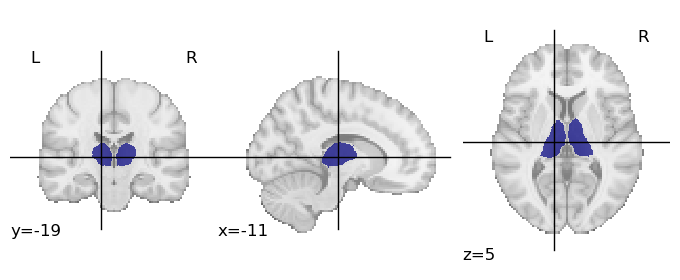

In [43]:
not_thalamus = ['ACC', 'M1', 'THA', 'GPe', 'GPi', 'PreSMA', 'SN', 'STN', 'STR', 'VTA',
                'lACC', 'lM1', 'lTHA', 'lGPe', 'lGPi', 'lPreSMA', 'lSN', 'lSTN', 'lSTR', 'lVTA',
                'rACC', 'rM1', 'rTHA', 'rGPe', 'rGPi', 'rPreSMA', 'rSN', 'rSTN', 'rSTR', 'rVTA', 'rIFG', 'lLC', 'rLC',
                'lPUT', 'rPUT', 'lCN', 'rCN']

mask_regex = re.compile('.*_label-(?P<mask>\S+)_probseg.nii.gz')
thalamus_fns = sorted(glob.glob('../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-*_probseg.nii.gz'))
thalamus_fns = [x for x in thalamus_fns if not mask_regex.match(x)['mask'] in not_thalamus]
thalamus_fns

full_thalamus_binary = nilearn.image.math_img('nii > 0', nii=nilearn.image.mean_img(thalamus_fns))
full_thalamus_binary_fullfov = nilearn.image.resample_to_img(full_thalamus_binary, z_map_sat_intercept)
plotting.plot_roi(full_thalamus_binary_fullfov)

In [50]:
thalamus.affine

array([[   1.,    0.,    0.,  -96.],
       [   0.,    1.,    0., -132.],
       [   0.,    0.,    1.,  -78.],
       [   0.,    0.,    0.,    1.]])

In [51]:
thalamus = nilearn.image.concat_imgs(thalamus_fns)
data = thalamus.get_fdata()
out = []
for fn in thalamus_fns:
    out.append(pd.DataFrame({'mask': fn.split('-')[-1].split('_')[0],
                             'n_vox':  nib.load(fn).get_fdata().sum()}, index=[0]))
    
out = pd.concat(out)

## Which regions have 150 voxels (at 1mm resolution) or more?
out.loc[out['n_vox']>150]

# so we need AV, CM, IPL, MDl, MDm, PuA, PuI, PuL, PuM, VA, VLa, VLp, VPL
# 13 -> 26 regions bilaterally

mask   n_vox
0   lAV   244.0
0   lCM   368.0
0  lLGN   244.0
0   lLP   222.0
0  lMDl   274.0
0  lMDm   769.0
0  lPuA   205.0
0  lPuI   397.0
0  lPuL   256.0
0  lPuM  1367.0
0   lVA   658.0
0  lVLa   826.0
0  lVLp  1202.0
0  lVPL  1199.0
0   rAV   246.0
0   rCM   358.0
0   rLP   196.0
0  rMDl   279.0
0  rMDm   723.0
0  rPuA   186.0
0  rPuI   383.0
0  rPuL   223.0
0  rPuM  1352.0
0   rVA   640.0
0  rVLa   846.0
0  rVLp  1135.0
0  rVPL  1137.0

### Mask stat map with thalamus mask

In [56]:
from nilearn.regions import connected_regions

def get_proportions_thalamus_subrois(stat_map, threshold, plot_rois=False):
    thresholded_zmap = nilearn.image.math_img('nii * mask', nii=stat_map, mask=full_thalamus_binary_fullfov)
    thresholded_zmap = nilearn.image.math_img('np.abs(nii) >= {}'.format(np.max([threshold, 3.1]), np.max([threshold, 3.1])), nii=thresholded_zmap)
    
    regions_percentile_img, index = connected_regions(thresholded_zmap, min_region_size=100, extract_type='connected_components')
    
    if plot_rois:
        for indx in range(regions_percentile_img.shape[-1]):
            plotting.plot_roi(nilearn.image.index_img(regions_percentile_img, indx), title=indx)
    
    all_proportions = []
    for mask_fn in thalamus_fns:
        mask = nilearn.image.resample_to_img(mask_fn, nilearn.image.index_img(regions_percentile_img, 0))
        mask_name = mask_regex.match(mask_fn)['mask']

        # for hemisphere in ['left', 'right'], [thalamic_cluster1, thalamic_cluster2]):
        for indx in range(regions_percentile_img.shape[-1]):
            cluster = nilearn.image.index_img(regions_percentile_img, indx)
            proportion = (cluster.get_fdata().astype(int) & mask.get_fdata().astype(int)).sum() / cluster.get_fdata().sum()
            all_proportions.append(pd.DataFrame({'mask': mask_name, 'cluster_indx': indx, 'p': proportion}, index=[0]))
            
    return pd.concat(all_proportions)

In [65]:
# df.set_index(['cluster_indx']).pivot(columns='mask_nohemi', values='p')

In [57]:
stat_map = z_map_sat_intercept
threshold = np.max([threshold_sat_fdr, 3.1])

thresholded_zmap = nilearn.image.math_img('nii * mask', nii=stat_map, mask=full_thalamus_binary_fullfov)
thresholded_zmap = nilearn.image.math_img('np.abs(nii) >= {}'.format(np.max([threshold, 3.1]), np.max([threshold, 3.1])), nii=thresholded_zmap)
#plotting.plot_stat_map(thresholded_zmap)


##
regions_percentile_img, index = connected_regions(thresholded_zmap, min_region_size=0, extract_type='connected_components')
##

mask_nohemi        CM       MDl       MDm       PuM        VA       VLa  \
left         0.091743  0.069805  0.107698       NaN       NaN  0.144396   
right        0.131850  0.058920  0.103832  0.061805  0.084466  0.158632   

mask_nohemi       VLp       VPL  
left         0.238532  0.151974  
right        0.114957  0.082406

left     0.177503
right    0.162752
dtype: float64

left     0.382928
right    0.273589
dtype: float64

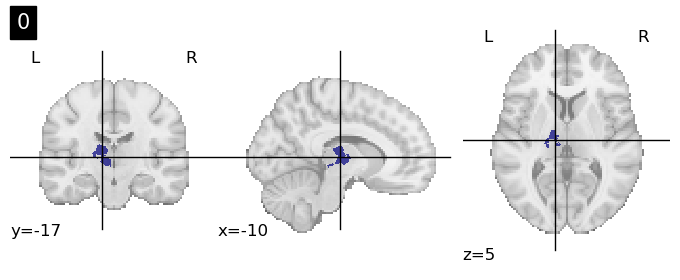

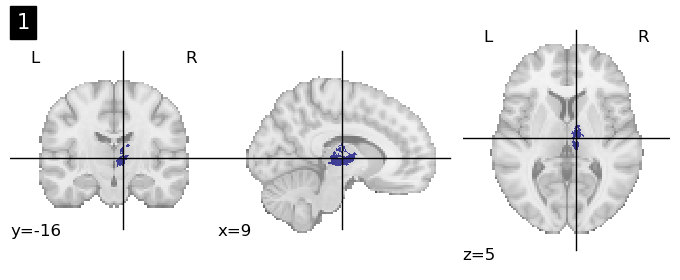

In [69]:
df = get_proportions_thalamus_subrois(z_map_sat_intercept, threshold_sat_fdr, plot_rois=True)

#df = get_proportions_thalamus_subrois(z_map_sat_intercept, np.max([threshold_sat_fdr, 3.1]), plot_rois=True)
df = df[df.p > 0.05]  # only look at proportions larger than 5% of cluster size

df['mask_nohemi'] = df['mask'].apply(lambda x: x[1:])
proportions = df.set_index(['cluster_indx']).pivot(columns='mask_nohemi', values='p')
proportions.index = ['left', 'right']
display(proportions)

# Sum MDl and MDm
display(proportions['MDl'] + proportions['MDm'])
display(proportions['VLa'] + proportions['VLp'])

## left-right

mask_nohemi         CM       PuL       VLa       VLp       VPL
cluster_indx                                                  
0                  NaN       NaN  0.104585  0.393983  0.498567
1             0.074349  0.056824  0.112586  0.335635  0.374403

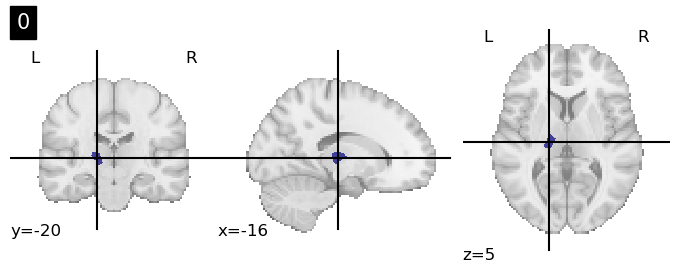

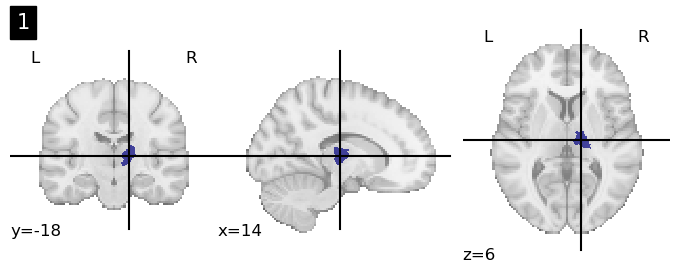

In [54]:
df = get_proportions_thalamus_subrois(z_map_responselr_intercept, np.max([threshold_responselr_fdr, 3.1]), plot_rois=True)
df = df[df.p > 0.05]  # only look at proportions larger than 5% of cluster size

df['mask_nohemi'] = df['mask'].apply(lambda x: x[1:])
df.set_index(['cluster_indx']).pivot(columns='mask_nohemi', values='p')

In [91]:
thresholded_zmap = nilearn.image.math_img('nii * mask', nii=z_map_sat_intercept, mask=full_thalamus_binary_fullfov)
thresholded_zmap = nilearn.image.math_img('nii >= {}'.format(np.max([threshold_sat_fdr, 3.1])), nii=thresholded_zmap)

In [92]:
regions_percentile_img, index = connected_regions(thresholded_zmap, min_region_size=100)

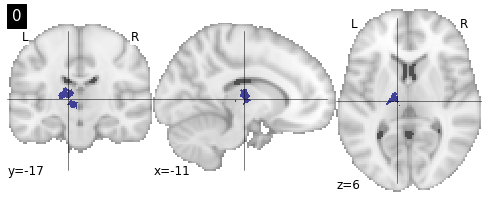

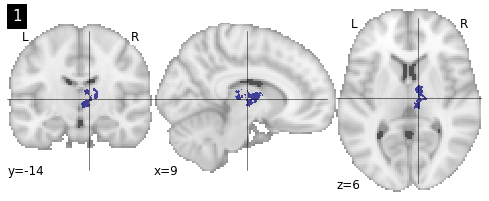

In [95]:
thalamic_cluster1 = nilearn.image.index_img(regions_percentile_img, 0)
thalamic_cluster2 = nilearn.image.index_img(regions_percentile_img, 1)

## where are we in the thalamus?

In [130]:
all_proportions = []
for mask_fn in thalamus_fns:
    mask = nilearn.image.resample_to_img(mask_fn, thalamic_cluster1)
    mask_name = mask_regex.match(mask_fn)['mask']
    
    for hemisphere, cluster in zip(['left', 'right'], [thalamic_cluster1, thalamic_cluster2]):
        proportion = (cluster.get_fdata().astype(int) & mask.get_fdata().astype(int)).sum() / cluster.get_fdata().sum()
        all_proportions.append(pd.DataFrame({'mask': mask_name[1:], 'hemisphere': hemisphere, 'p': proportion}, index=[0]))

In [132]:
props = pd.concat(all_proportions) #.set_index(['hemisphere']).pivot(columns='mask', values='p')
props = props[props.p > 0.05]
props.set_index(['hemisphere']).pivot(columns='mask', values='p')

mask              CM       MDl       MDm       PuM        VA       VLa  \
hemisphere                                                               
left        0.077723  0.065134  0.126984       NaN       NaN  0.112753   
right       0.063529  0.052157  0.086667  0.071765  0.118824  0.196471   

mask             VLp       VPL  
hemisphere                      
left        0.303777  0.158183  
right       0.158431  0.077647